In [1]:
#Example from https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw



In [3]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [5]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [6]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [7]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253000
	 partial train loss (single batch): 0.246744
	 partial train loss (single batch): 0.240435
	 partial train loss (single batch): 0.235994
	 partial train loss (single batch): 0.231887
	 partial train loss (single batch): 0.228230
	 partial train loss (single batch): 0.225168
	 partial train loss (single batch): 0.222740
	 partial train loss (single batch): 0.220122
	 partial train loss (single batch): 0.218445
	 partial train loss (single batch): 0.216131
	 partial train loss (single batch): 0.213638
	 partial train loss (single batch): 0.211799
	 partial train loss (single batch): 0.209579
	 partial train loss (single batch): 0.207583
	 partial train loss (single batch): 0.205203
	 partial train loss (single batch): 0.203412
	 partial train loss (single batch): 0.201563
	 partial train loss (single batch): 0.199806
	 partial train loss (single batch): 0.197832
	 partial train loss (single batch): 0.195243
	 partial train loss (single batch

	 partial train loss (single batch): 0.067020
	 partial train loss (single batch): 0.067795
	 partial train loss (single batch): 0.066290
	 partial train loss (single batch): 0.067167
	 partial train loss (single batch): 0.066537
	 partial train loss (single batch): 0.067467
	 partial train loss (single batch): 0.065925
	 partial train loss (single batch): 0.064593

 EPOCH 1/30 	 train loss 0.12264587730169296 	 val loss 0.0645001009106636


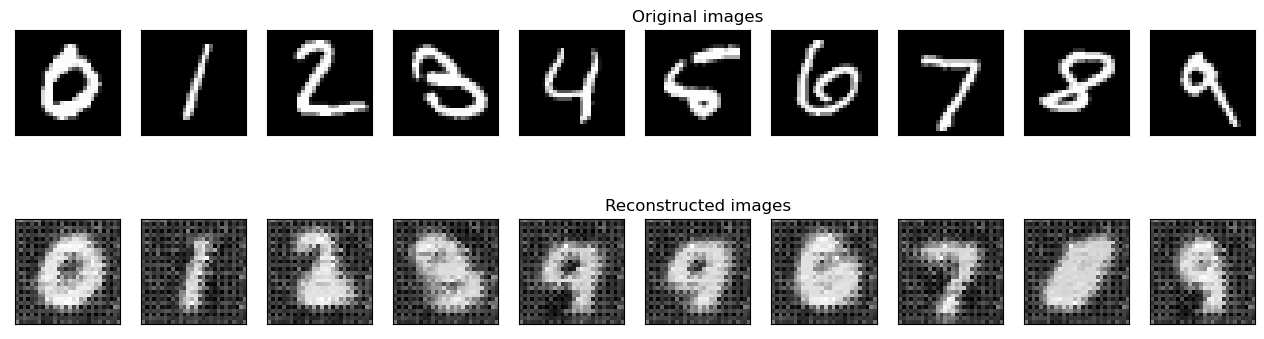

	 partial train loss (single batch): 0.066479
	 partial train loss (single batch): 0.065182
	 partial train loss (single batch): 0.065654
	 partial train loss (single batch): 0.064801
	 partial train loss (single batch): 0.064532
	 partial train loss (single batch): 0.064928
	 partial train loss (single batch): 0.064094
	 partial train loss (single batch): 0.064070
	 partial train loss (single batch): 0.064344
	 partial train loss (single batch): 0.062576
	 partial train loss (single batch): 0.063310
	 partial train loss (single batch): 0.063594
	 partial train loss (single batch): 0.062469
	 partial train loss (single batch): 0.063771
	 partial train loss (single batch): 0.062882
	 partial train loss (single batch): 0.061975
	 partial train loss (single batch): 0.063106
	 partial train loss (single batch): 0.061643
	 partial train loss (single batch): 0.060191
	 partial train loss (single batch): 0.061126
	 partial train loss (single batch): 0.061541
	 partial train loss (single batch

	 partial train loss (single batch): 0.047279
	 partial train loss (single batch): 0.046585
	 partial train loss (single batch): 0.047855
	 partial train loss (single batch): 0.045693
	 partial train loss (single batch): 0.047319
	 partial train loss (single batch): 0.047109
	 partial train loss (single batch): 0.048229
	 partial train loss (single batch): 0.046605
	 partial train loss (single batch): 0.045297

 EPOCH 2/30 	 train loss 0.05350164696574211 	 val loss 0.046882178634405136


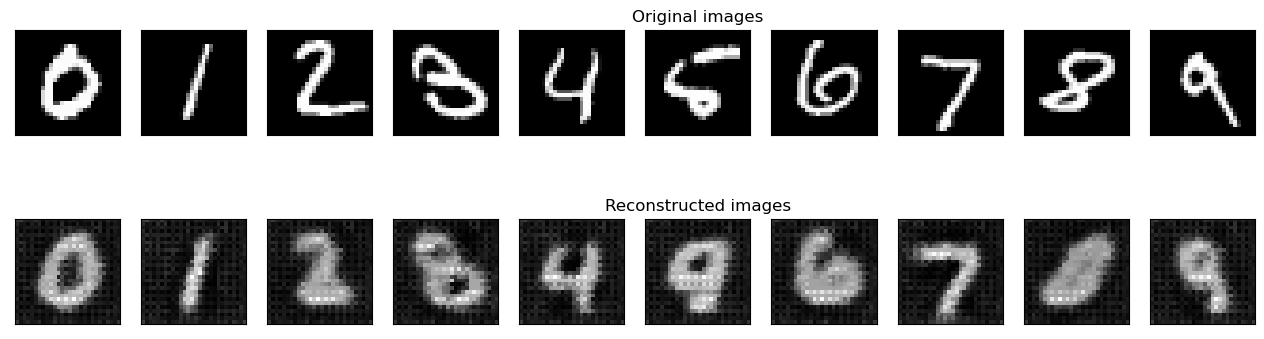

	 partial train loss (single batch): 0.047809
	 partial train loss (single batch): 0.046056
	 partial train loss (single batch): 0.046696
	 partial train loss (single batch): 0.046167
	 partial train loss (single batch): 0.045642
	 partial train loss (single batch): 0.046912
	 partial train loss (single batch): 0.046222
	 partial train loss (single batch): 0.046282
	 partial train loss (single batch): 0.046966
	 partial train loss (single batch): 0.044930
	 partial train loss (single batch): 0.045829
	 partial train loss (single batch): 0.046323
	 partial train loss (single batch): 0.045396
	 partial train loss (single batch): 0.046786
	 partial train loss (single batch): 0.045725
	 partial train loss (single batch): 0.045428
	 partial train loss (single batch): 0.047012
	 partial train loss (single batch): 0.045704
	 partial train loss (single batch): 0.043952
	 partial train loss (single batch): 0.045334
	 partial train loss (single batch): 0.046263
	 partial train loss (single batch

	 partial train loss (single batch): 0.037526
	 partial train loss (single batch): 0.038587
	 partial train loss (single batch): 0.035933
	 partial train loss (single batch): 0.037924
	 partial train loss (single batch): 0.037707
	 partial train loss (single batch): 0.038643
	 partial train loss (single batch): 0.037311
	 partial train loss (single batch): 0.036606

 EPOCH 3/30 	 train loss 0.041580669581890106 	 val loss 0.03734472021460533


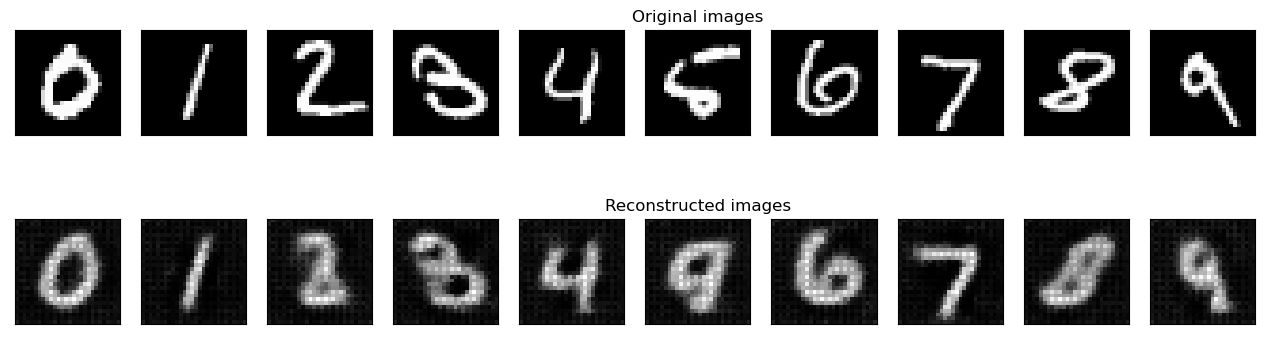

	 partial train loss (single batch): 0.038323
	 partial train loss (single batch): 0.037121
	 partial train loss (single batch): 0.037581
	 partial train loss (single batch): 0.037090
	 partial train loss (single batch): 0.036155
	 partial train loss (single batch): 0.037751
	 partial train loss (single batch): 0.037359
	 partial train loss (single batch): 0.037479
	 partial train loss (single batch): 0.037862
	 partial train loss (single batch): 0.036069
	 partial train loss (single batch): 0.036720
	 partial train loss (single batch): 0.037021
	 partial train loss (single batch): 0.036909
	 partial train loss (single batch): 0.037452
	 partial train loss (single batch): 0.036450
	 partial train loss (single batch): 0.035947
	 partial train loss (single batch): 0.038196
	 partial train loss (single batch): 0.037155
	 partial train loss (single batch): 0.035131
	 partial train loss (single batch): 0.036949
	 partial train loss (single batch): 0.037888
	 partial train loss (single batch

	 partial train loss (single batch): 0.032910
	 partial train loss (single batch): 0.034064
	 partial train loss (single batch): 0.031439
	 partial train loss (single batch): 0.033256
	 partial train loss (single batch): 0.033219
	 partial train loss (single batch): 0.034274
	 partial train loss (single batch): 0.032981
	 partial train loss (single batch): 0.032125

 EPOCH 4/30 	 train loss 0.034823812544345856 	 val loss 0.03312528133392334


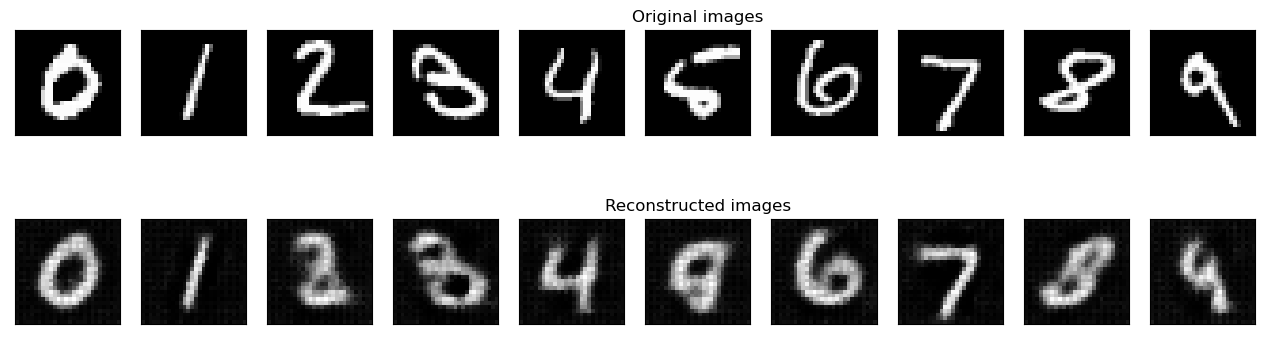

	 partial train loss (single batch): 0.033688
	 partial train loss (single batch): 0.033002
	 partial train loss (single batch): 0.033399
	 partial train loss (single batch): 0.032889
	 partial train loss (single batch): 0.032119
	 partial train loss (single batch): 0.033764
	 partial train loss (single batch): 0.033344
	 partial train loss (single batch): 0.033400
	 partial train loss (single batch): 0.033416
	 partial train loss (single batch): 0.032396
	 partial train loss (single batch): 0.032729
	 partial train loss (single batch): 0.033023
	 partial train loss (single batch): 0.033277
	 partial train loss (single batch): 0.033386
	 partial train loss (single batch): 0.032323
	 partial train loss (single batch): 0.031765
	 partial train loss (single batch): 0.034273
	 partial train loss (single batch): 0.033431
	 partial train loss (single batch): 0.031396
	 partial train loss (single batch): 0.033372
	 partial train loss (single batch): 0.034110
	 partial train loss (single batch

	 partial train loss (single batch): 0.030834
	 partial train loss (single batch): 0.031884
	 partial train loss (single batch): 0.029557
	 partial train loss (single batch): 0.031073
	 partial train loss (single batch): 0.031402
	 partial train loss (single batch): 0.032303
	 partial train loss (single batch): 0.031177
	 partial train loss (single batch): 0.030125

 EPOCH 5/30 	 train loss 0.031998734921216965 	 val loss 0.031299564987421036


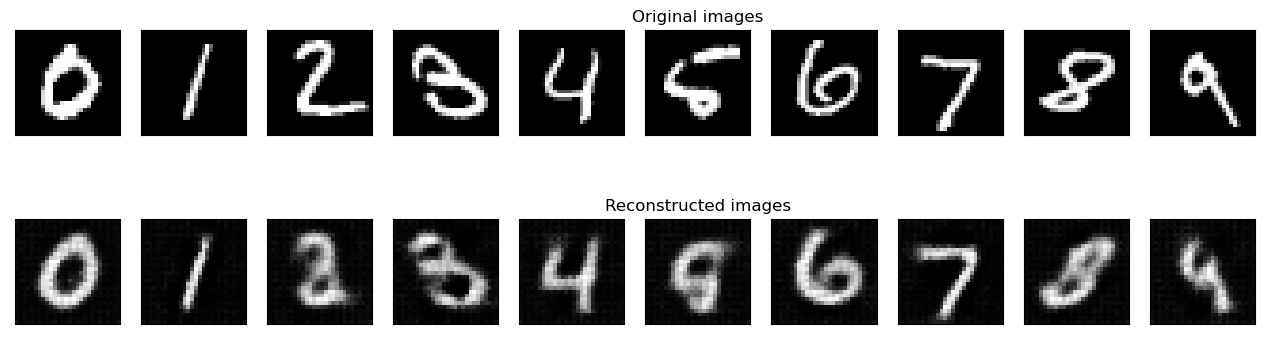

	 partial train loss (single batch): 0.031875
	 partial train loss (single batch): 0.031194
	 partial train loss (single batch): 0.031588
	 partial train loss (single batch): 0.031113
	 partial train loss (single batch): 0.030150
	 partial train loss (single batch): 0.032121
	 partial train loss (single batch): 0.031621
	 partial train loss (single batch): 0.031586
	 partial train loss (single batch): 0.031585
	 partial train loss (single batch): 0.030714
	 partial train loss (single batch): 0.030905
	 partial train loss (single batch): 0.031055
	 partial train loss (single batch): 0.031433
	 partial train loss (single batch): 0.031604
	 partial train loss (single batch): 0.030371
	 partial train loss (single batch): 0.029676
	 partial train loss (single batch): 0.032406
	 partial train loss (single batch): 0.031947
	 partial train loss (single batch): 0.029592
	 partial train loss (single batch): 0.031606
	 partial train loss (single batch): 0.032466
	 partial train loss (single batch

	 partial train loss (single batch): 0.029566
	 partial train loss (single batch): 0.030582
	 partial train loss (single batch): 0.028596
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.030192
	 partial train loss (single batch): 0.031191
	 partial train loss (single batch): 0.029868
	 partial train loss (single batch): 0.029024

 EPOCH 6/30 	 train loss 0.030588505789637566 	 val loss 0.030182238668203354


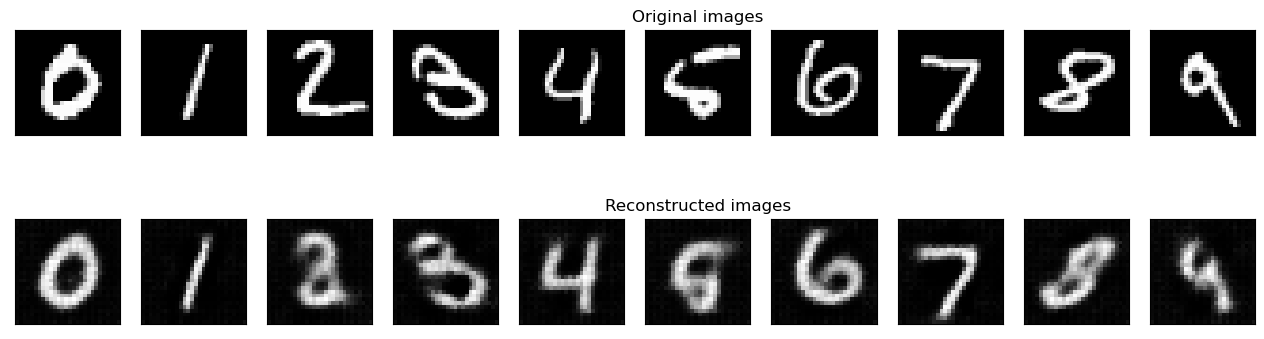

	 partial train loss (single batch): 0.030770
	 partial train loss (single batch): 0.030061
	 partial train loss (single batch): 0.030525
	 partial train loss (single batch): 0.030147
	 partial train loss (single batch): 0.028947
	 partial train loss (single batch): 0.031111
	 partial train loss (single batch): 0.030657
	 partial train loss (single batch): 0.030536
	 partial train loss (single batch): 0.030411
	 partial train loss (single batch): 0.029806
	 partial train loss (single batch): 0.029790
	 partial train loss (single batch): 0.029933
	 partial train loss (single batch): 0.030288
	 partial train loss (single batch): 0.030504
	 partial train loss (single batch): 0.029204
	 partial train loss (single batch): 0.028576
	 partial train loss (single batch): 0.031372
	 partial train loss (single batch): 0.031047
	 partial train loss (single batch): 0.028667
	 partial train loss (single batch): 0.030635
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch

	 partial train loss (single batch): 0.028800
	 partial train loss (single batch): 0.029726
	 partial train loss (single batch): 0.027939
	 partial train loss (single batch): 0.029198
	 partial train loss (single batch): 0.029328
	 partial train loss (single batch): 0.030315
	 partial train loss (single batch): 0.029165
	 partial train loss (single batch): 0.028108

 EPOCH 7/30 	 train loss 0.029700929298996925 	 val loss 0.02943020686507225


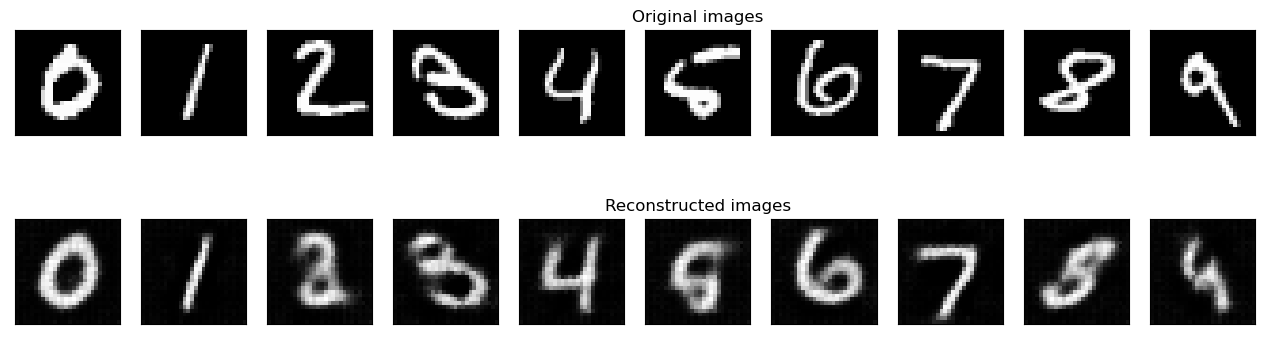

	 partial train loss (single batch): 0.030013
	 partial train loss (single batch): 0.029384
	 partial train loss (single batch): 0.029752
	 partial train loss (single batch): 0.029472
	 partial train loss (single batch): 0.028215
	 partial train loss (single batch): 0.030407
	 partial train loss (single batch): 0.029948
	 partial train loss (single batch): 0.029818
	 partial train loss (single batch): 0.029590
	 partial train loss (single batch): 0.029076
	 partial train loss (single batch): 0.028945
	 partial train loss (single batch): 0.029210
	 partial train loss (single batch): 0.029572
	 partial train loss (single batch): 0.029866
	 partial train loss (single batch): 0.028534
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.030648
	 partial train loss (single batch): 0.030429
	 partial train loss (single batch): 0.028079
	 partial train loss (single batch): 0.029793
	 partial train loss (single batch): 0.030729
	 partial train loss (single batch

	 partial train loss (single batch): 0.028208
	 partial train loss (single batch): 0.029024
	 partial train loss (single batch): 0.027393
	 partial train loss (single batch): 0.028657
	 partial train loss (single batch): 0.028833
	 partial train loss (single batch): 0.029738
	 partial train loss (single batch): 0.028644
	 partial train loss (single batch): 0.027607

 EPOCH 8/30 	 train loss 0.029085349291563034 	 val loss 0.028889082372188568


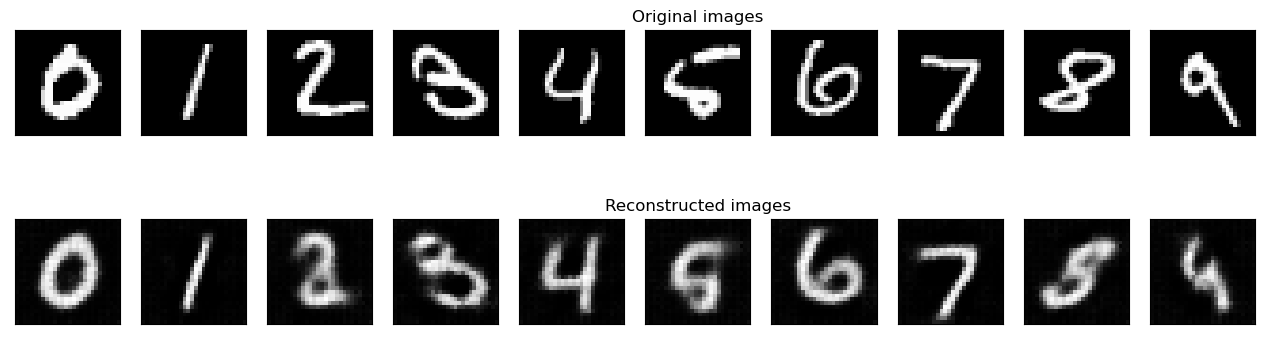

	 partial train loss (single batch): 0.029505
	 partial train loss (single batch): 0.028827
	 partial train loss (single batch): 0.029222
	 partial train loss (single batch): 0.029030
	 partial train loss (single batch): 0.027636
	 partial train loss (single batch): 0.029969
	 partial train loss (single batch): 0.029339
	 partial train loss (single batch): 0.029280
	 partial train loss (single batch): 0.028988
	 partial train loss (single batch): 0.028526
	 partial train loss (single batch): 0.028400
	 partial train loss (single batch): 0.028700
	 partial train loss (single batch): 0.028934
	 partial train loss (single batch): 0.029384
	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.027284
	 partial train loss (single batch): 0.030065
	 partial train loss (single batch): 0.029985
	 partial train loss (single batch): 0.027653
	 partial train loss (single batch): 0.029171
	 partial train loss (single batch): 0.030108
	 partial train loss (single batch

	 partial train loss (single batch): 0.027859
	 partial train loss (single batch): 0.028602
	 partial train loss (single batch): 0.026970
	 partial train loss (single batch): 0.028211
	 partial train loss (single batch): 0.028384
	 partial train loss (single batch): 0.029388
	 partial train loss (single batch): 0.028218
	 partial train loss (single batch): 0.027169

 EPOCH 9/30 	 train loss 0.02863139472901821 	 val loss 0.02845468744635582


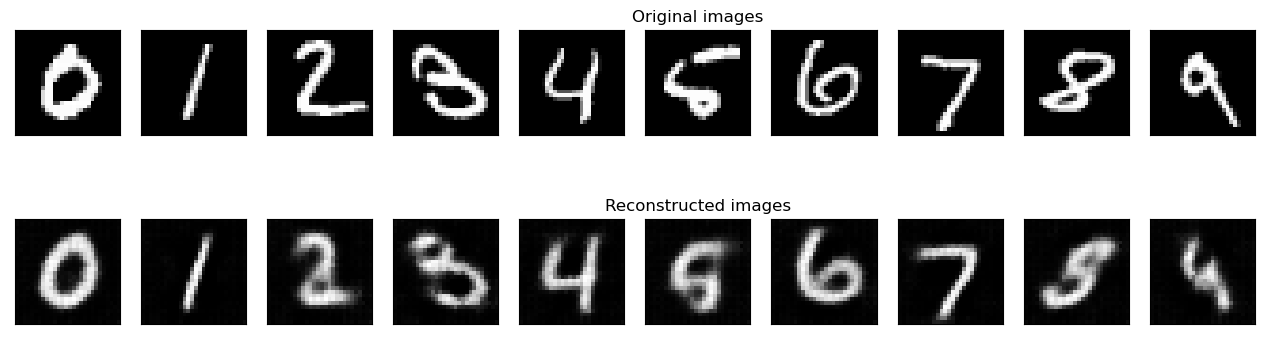

	 partial train loss (single batch): 0.029159
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.028734
	 partial train loss (single batch): 0.028824
	 partial train loss (single batch): 0.027223
	 partial train loss (single batch): 0.029543
	 partial train loss (single batch): 0.028810
	 partial train loss (single batch): 0.029041
	 partial train loss (single batch): 0.028524
	 partial train loss (single batch): 0.028189
	 partial train loss (single batch): 0.028038
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.028559
	 partial train loss (single batch): 0.028928
	 partial train loss (single batch): 0.027505
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.029685
	 partial train loss (single batch): 0.029648
	 partial train loss (single batch): 0.027309
	 partial train loss (single batch): 0.028795
	 partial train loss (single batch): 0.029631
	 partial train loss (single batch

	 partial train loss (single batch): 0.027517
	 partial train loss (single batch): 0.028245
	 partial train loss (single batch): 0.026692
	 partial train loss (single batch): 0.027928
	 partial train loss (single batch): 0.028084
	 partial train loss (single batch): 0.029002
	 partial train loss (single batch): 0.027834
	 partial train loss (single batch): 0.026918

 EPOCH 10/30 	 train loss 0.028272826224565506 	 val loss 0.028154710307717323


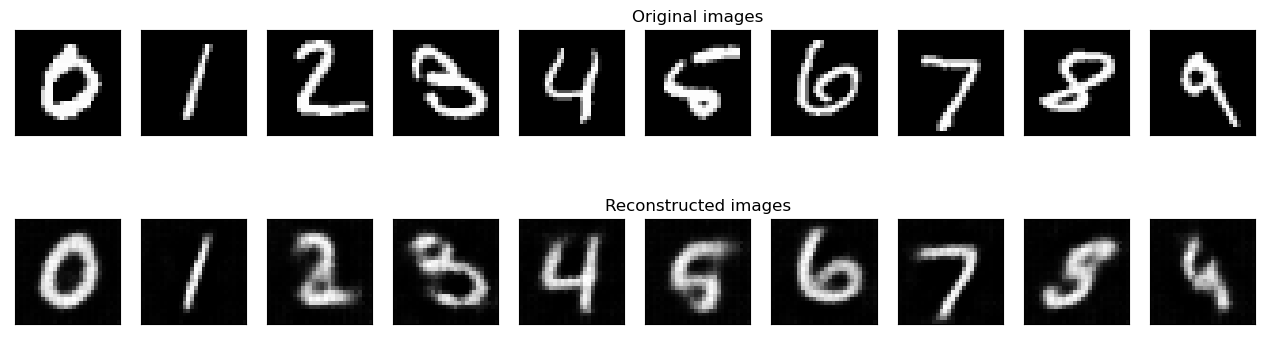

	 partial train loss (single batch): 0.028837
	 partial train loss (single batch): 0.028003
	 partial train loss (single batch): 0.028354
	 partial train loss (single batch): 0.028563
	 partial train loss (single batch): 0.026865
	 partial train loss (single batch): 0.029233
	 partial train loss (single batch): 0.028400
	 partial train loss (single batch): 0.028743
	 partial train loss (single batch): 0.028142
	 partial train loss (single batch): 0.027870
	 partial train loss (single batch): 0.027721
	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.028120
	 partial train loss (single batch): 0.028661
	 partial train loss (single batch): 0.027210
	 partial train loss (single batch): 0.026730
	 partial train loss (single batch): 0.029421
	 partial train loss (single batch): 0.029281
	 partial train loss (single batch): 0.027009
	 partial train loss (single batch): 0.028462
	 partial train loss (single batch): 0.029304
	 partial train loss (single batch

	 partial train loss (single batch): 0.027302
	 partial train loss (single batch): 0.027950
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.027867
	 partial train loss (single batch): 0.028726
	 partial train loss (single batch): 0.027590
	 partial train loss (single batch): 0.026644

 EPOCH 11/30 	 train loss 0.02796642854809761 	 val loss 0.0279143825173378


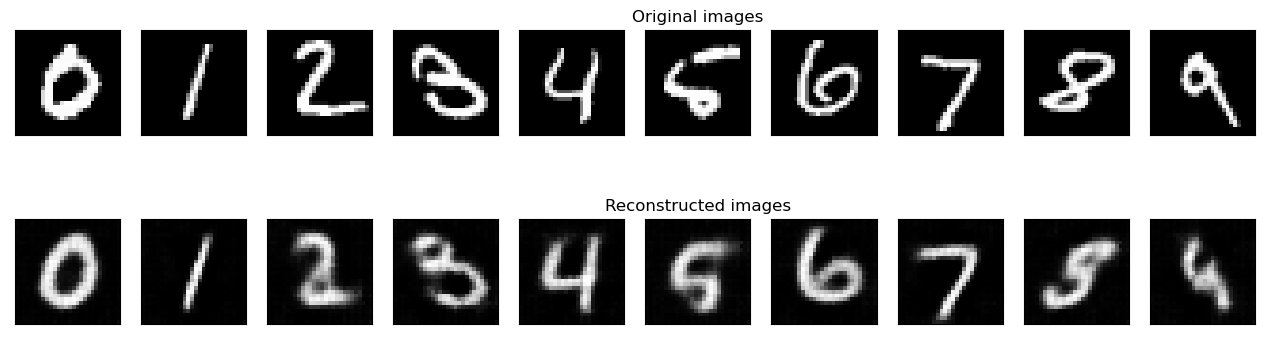

	 partial train loss (single batch): 0.028634
	 partial train loss (single batch): 0.027716
	 partial train loss (single batch): 0.028063
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.029029
	 partial train loss (single batch): 0.027994
	 partial train loss (single batch): 0.028438
	 partial train loss (single batch): 0.027786
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.027491
	 partial train loss (single batch): 0.027764
	 partial train loss (single batch): 0.027822
	 partial train loss (single batch): 0.028366
	 partial train loss (single batch): 0.026852
	 partial train loss (single batch): 0.026391
	 partial train loss (single batch): 0.029158
	 partial train loss (single batch): 0.029093
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.028173
	 partial train loss (single batch): 0.029056
	 partial train loss (single batch

	 partial train loss (single batch): 0.027725
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.027549
	 partial train loss (single batch): 0.028391
	 partial train loss (single batch): 0.027340
	 partial train loss (single batch): 0.026413

 EPOCH 12/30 	 train loss 0.027700593695044518 	 val loss 0.0277062077075243


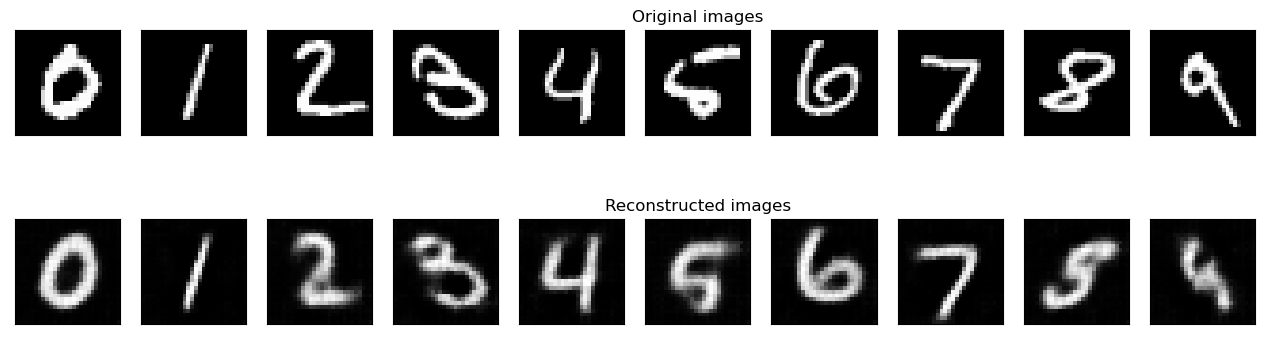

	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.027526
	 partial train loss (single batch): 0.027823
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.028768
	 partial train loss (single batch): 0.027663
	 partial train loss (single batch): 0.028256
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.027365
	 partial train loss (single batch): 0.027286
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.027575
	 partial train loss (single batch): 0.028173
	 partial train loss (single batch): 0.026622
	 partial train loss (single batch): 0.026157
	 partial train loss (single batch): 0.028957
	 partial train loss (single batch): 0.028874
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.027947
	 partial train loss (single batch): 0.028899
	 partial train loss (single batch

	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.027519
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.027295
	 partial train loss (single batch): 0.027266
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.027170
	 partial train loss (single batch): 0.026339

 EPOCH 13/30 	 train loss 0.027483195066452026 	 val loss 0.02748516947031021


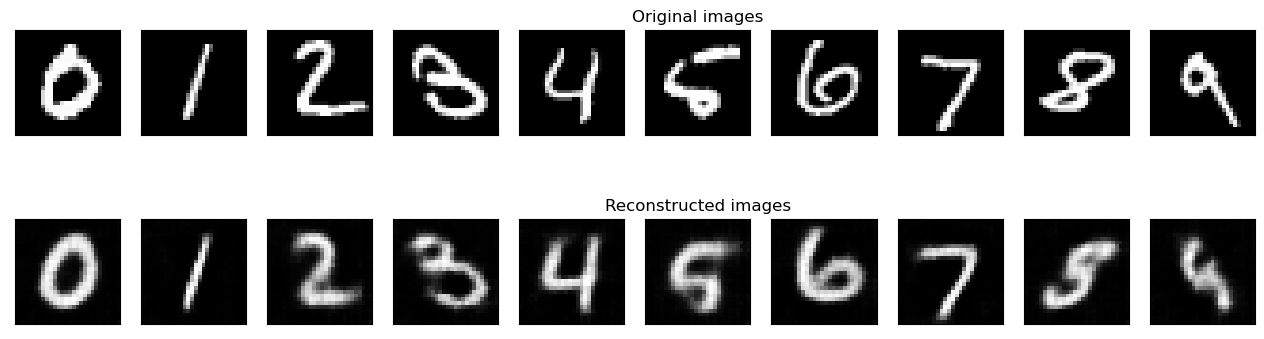

	 partial train loss (single batch): 0.028156
	 partial train loss (single batch): 0.027208
	 partial train loss (single batch): 0.027603
	 partial train loss (single batch): 0.027909
	 partial train loss (single batch): 0.026110
	 partial train loss (single batch): 0.028552
	 partial train loss (single batch): 0.027476
	 partial train loss (single batch): 0.028160
	 partial train loss (single batch): 0.027268
	 partial train loss (single batch): 0.027241
	 partial train loss (single batch): 0.027141
	 partial train loss (single batch): 0.027259
	 partial train loss (single batch): 0.027457
	 partial train loss (single batch): 0.028001
	 partial train loss (single batch): 0.026450
	 partial train loss (single batch): 0.026001
	 partial train loss (single batch): 0.028775
	 partial train loss (single batch): 0.028710
	 partial train loss (single batch): 0.026330
	 partial train loss (single batch): 0.027725
	 partial train loss (single batch): 0.028644
	 partial train loss (single batch

	 partial train loss (single batch): 0.026724
	 partial train loss (single batch): 0.027219
	 partial train loss (single batch): 0.025810
	 partial train loss (single batch): 0.027191
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch): 0.028024
	 partial train loss (single batch): 0.027045
	 partial train loss (single batch): 0.026226

 EPOCH 14/30 	 train loss 0.027289897203445435 	 val loss 0.02735765650868416


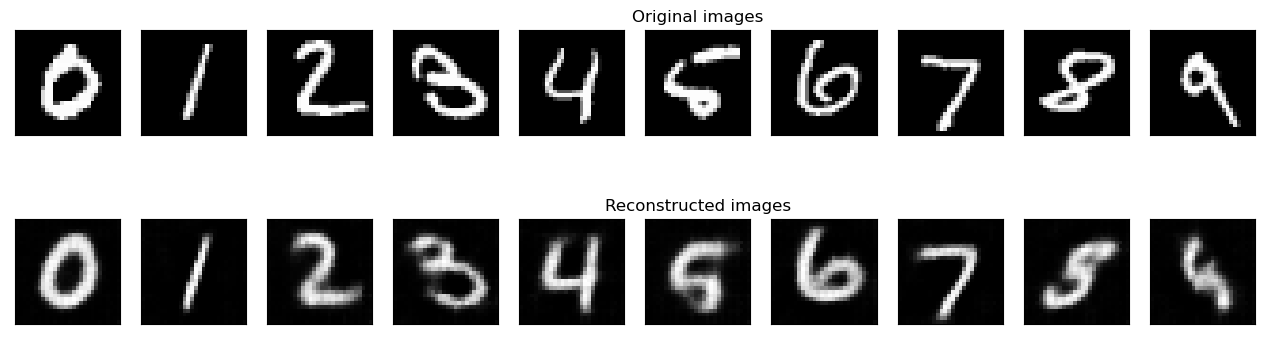

	 partial train loss (single batch): 0.028021
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.027367
	 partial train loss (single batch): 0.027707
	 partial train loss (single batch): 0.025962
	 partial train loss (single batch): 0.028403
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.027959
	 partial train loss (single batch): 0.026978
	 partial train loss (single batch): 0.027029
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.027038
	 partial train loss (single batch): 0.027143
	 partial train loss (single batch): 0.027891
	 partial train loss (single batch): 0.026230
	 partial train loss (single batch): 0.025792
	 partial train loss (single batch): 0.028508
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.026205
	 partial train loss (single batch): 0.027512
	 partial train loss (single batch): 0.028522
	 partial train loss (single batch

	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.027093
	 partial train loss (single batch): 0.025637
	 partial train loss (single batch): 0.026950
	 partial train loss (single batch): 0.026941
	 partial train loss (single batch): 0.027842
	 partial train loss (single batch): 0.026854
	 partial train loss (single batch): 0.026231

 EPOCH 15/30 	 train loss 0.02711976319551468 	 val loss 0.027213172987103462


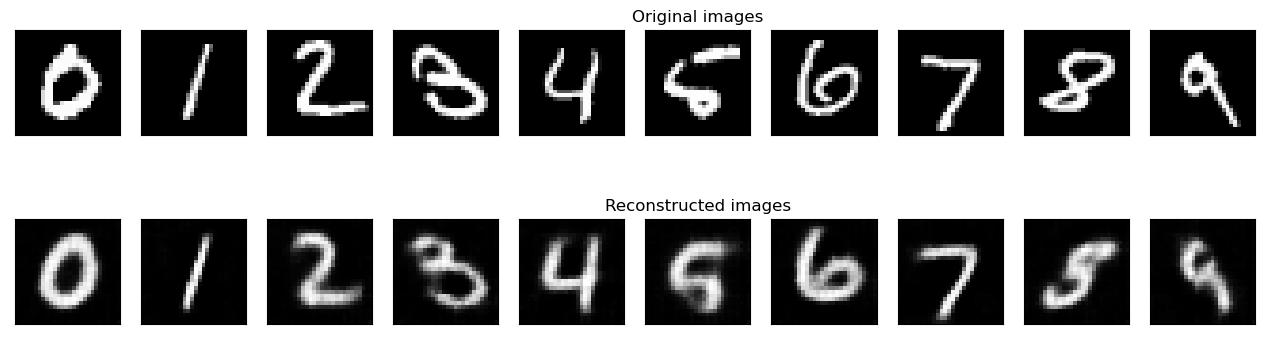

	 partial train loss (single batch): 0.027892
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.027218
	 partial train loss (single batch): 0.027585
	 partial train loss (single batch): 0.025857
	 partial train loss (single batch): 0.028217
	 partial train loss (single batch): 0.027063
	 partial train loss (single batch): 0.027822
	 partial train loss (single batch): 0.026842
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.026851
	 partial train loss (single batch): 0.026876
	 partial train loss (single batch): 0.027049
	 partial train loss (single batch): 0.027760
	 partial train loss (single batch): 0.026108
	 partial train loss (single batch): 0.025688
	 partial train loss (single batch): 0.028356
	 partial train loss (single batch): 0.028467
	 partial train loss (single batch): 0.026056
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.028359
	 partial train loss (single batch

	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.025416
	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.026799
	 partial train loss (single batch): 0.027594
	 partial train loss (single batch): 0.026608
	 partial train loss (single batch): 0.026064

 EPOCH 16/30 	 train loss 0.026971101760864258 	 val loss 0.027070214971899986


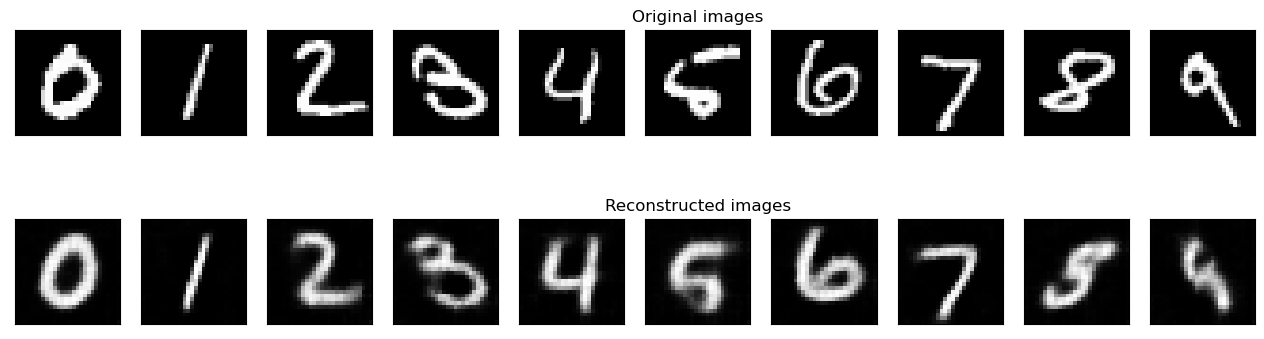

	 partial train loss (single batch): 0.027723
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.027479
	 partial train loss (single batch): 0.025662
	 partial train loss (single batch): 0.028134
	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.027648
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.026798
	 partial train loss (single batch): 0.026733
	 partial train loss (single batch): 0.026704
	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.025574
	 partial train loss (single batch): 0.028138
	 partial train loss (single batch): 0.028321
	 partial train loss (single batch): 0.025972
	 partial train loss (single batch): 0.027204
	 partial train loss (single batch): 0.028227
	 partial train loss (single batch

	 partial train loss (single batch): 0.026346
	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.025296
	 partial train loss (single batch): 0.026651
	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.027435
	 partial train loss (single batch): 0.026531
	 partial train loss (single batch): 0.026058

 EPOCH 17/30 	 train loss 0.026833007112145424 	 val loss 0.026969678699970245


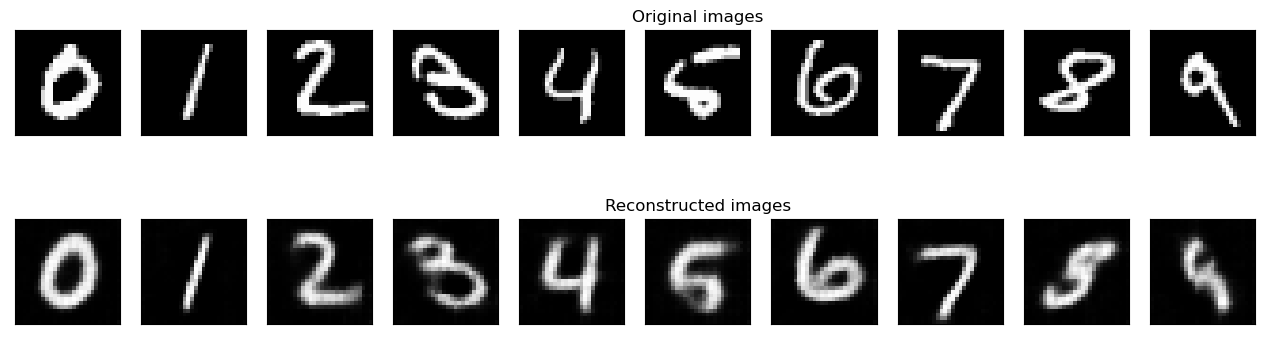

	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.026663
	 partial train loss (single batch): 0.026928
	 partial train loss (single batch): 0.027421
	 partial train loss (single batch): 0.025548
	 partial train loss (single batch): 0.027991
	 partial train loss (single batch): 0.026713
	 partial train loss (single batch): 0.027443
	 partial train loss (single batch): 0.026414
	 partial train loss (single batch): 0.026612
	 partial train loss (single batch): 0.026578
	 partial train loss (single batch): 0.026597
	 partial train loss (single batch): 0.026649
	 partial train loss (single batch): 0.027472
	 partial train loss (single batch): 0.025879
	 partial train loss (single batch): 0.025416
	 partial train loss (single batch): 0.027973
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.025821
	 partial train loss (single batch): 0.027073
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch

	 partial train loss (single batch): 0.026238
	 partial train loss (single batch): 0.026648
	 partial train loss (single batch): 0.025199
	 partial train loss (single batch): 0.026500
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.027435
	 partial train loss (single batch): 0.026412
	 partial train loss (single batch): 0.026043

 EPOCH 18/30 	 train loss 0.026717377826571465 	 val loss 0.02692350558936596


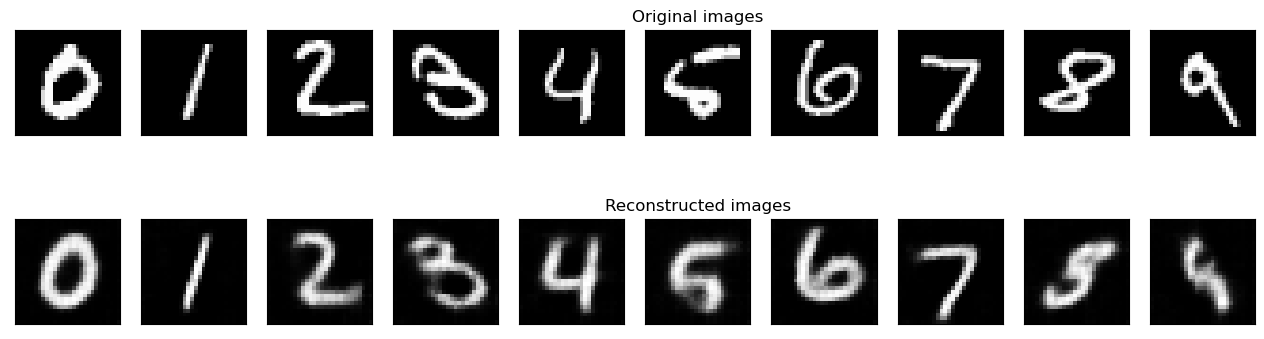

	 partial train loss (single batch): 0.027568
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.026822
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.025497
	 partial train loss (single batch): 0.027901
	 partial train loss (single batch): 0.026593
	 partial train loss (single batch): 0.027309
	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.026515
	 partial train loss (single batch): 0.026420
	 partial train loss (single batch): 0.026532
	 partial train loss (single batch): 0.026562
	 partial train loss (single batch): 0.027302
	 partial train loss (single batch): 0.025718
	 partial train loss (single batch): 0.025373
	 partial train loss (single batch): 0.027886
	 partial train loss (single batch): 0.028055
	 partial train loss (single batch): 0.025650
	 partial train loss (single batch): 0.026984
	 partial train loss (single batch): 0.027961
	 partial train loss (single batch

	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.025113
	 partial train loss (single batch): 0.026319
	 partial train loss (single batch): 0.026604
	 partial train loss (single batch): 0.027353
	 partial train loss (single batch): 0.026272
	 partial train loss (single batch): 0.025959

 EPOCH 19/30 	 train loss 0.026587877422571182 	 val loss 0.026828400790691376


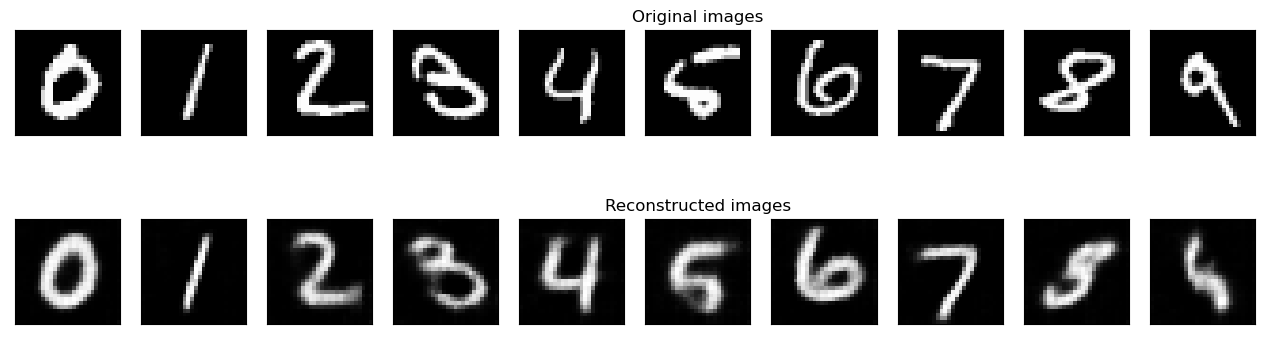

	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.026314
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.027228
	 partial train loss (single batch): 0.025327
	 partial train loss (single batch): 0.027836
	 partial train loss (single batch): 0.026486
	 partial train loss (single batch): 0.027212
	 partial train loss (single batch): 0.026185
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.026304
	 partial train loss (single batch): 0.026277
	 partial train loss (single batch): 0.026361
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.025551
	 partial train loss (single batch): 0.025238
	 partial train loss (single batch): 0.027830
	 partial train loss (single batch): 0.027873
	 partial train loss (single batch): 0.025507
	 partial train loss (single batch): 0.026827
	 partial train loss (single batch): 0.027829
	 partial train loss (single batch

	 partial train loss (single batch): 0.026089
	 partial train loss (single batch): 0.026403
	 partial train loss (single batch): 0.025074
	 partial train loss (single batch): 0.026255
	 partial train loss (single batch): 0.026444
	 partial train loss (single batch): 0.027327
	 partial train loss (single batch): 0.026183
	 partial train loss (single batch): 0.025805

 EPOCH 20/30 	 train loss 0.02648784965276718 	 val loss 0.026745373383164406


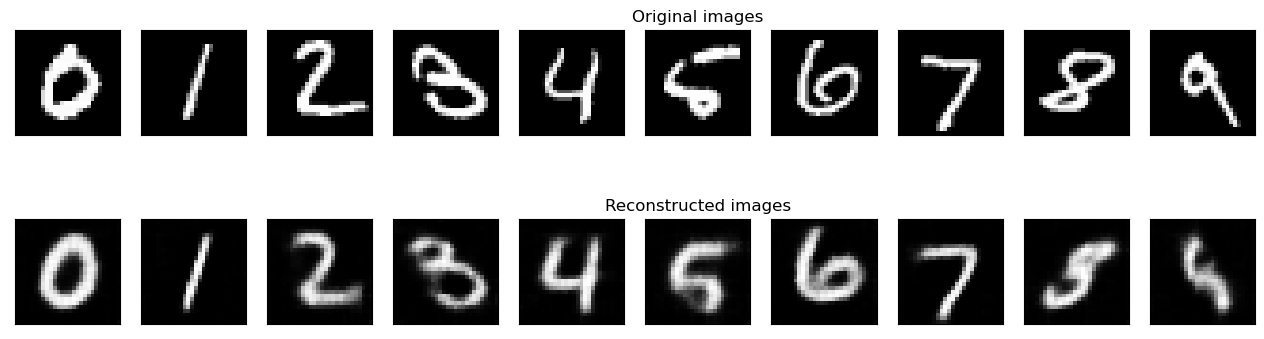

	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.026264
	 partial train loss (single batch): 0.026609
	 partial train loss (single batch): 0.027220
	 partial train loss (single batch): 0.025268
	 partial train loss (single batch): 0.027783
	 partial train loss (single batch): 0.026356
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.026295
	 partial train loss (single batch): 0.026253
	 partial train loss (single batch): 0.026138
	 partial train loss (single batch): 0.026327
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.025512
	 partial train loss (single batch): 0.025211
	 partial train loss (single batch): 0.027724
	 partial train loss (single batch): 0.027863
	 partial train loss (single batch): 0.025433
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.027764
	 partial train loss (single batch

	 partial train loss (single batch): 0.026052
	 partial train loss (single batch): 0.026374
	 partial train loss (single batch): 0.024909
	 partial train loss (single batch): 0.026190
	 partial train loss (single batch): 0.026394
	 partial train loss (single batch): 0.027237
	 partial train loss (single batch): 0.026149
	 partial train loss (single batch): 0.025805

 EPOCH 21/30 	 train loss 0.026381907984614372 	 val loss 0.026701094582676888


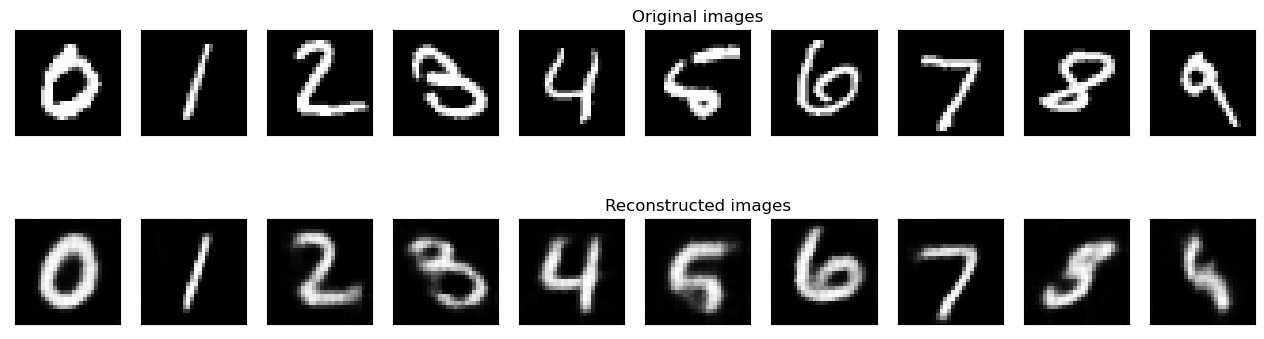

	 partial train loss (single batch): 0.027235
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.026467
	 partial train loss (single batch): 0.027163
	 partial train loss (single batch): 0.025201
	 partial train loss (single batch): 0.027697
	 partial train loss (single batch): 0.026295
	 partial train loss (single batch): 0.027027
	 partial train loss (single batch): 0.025963
	 partial train loss (single batch): 0.026227
	 partial train loss (single batch): 0.026150
	 partial train loss (single batch): 0.026093
	 partial train loss (single batch): 0.026226
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.025397
	 partial train loss (single batch): 0.025101
	 partial train loss (single batch): 0.027590
	 partial train loss (single batch): 0.027748
	 partial train loss (single batch): 0.025292
	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.027649
	 partial train loss (single batch

	 partial train loss (single batch): 0.026010
	 partial train loss (single batch): 0.026387
	 partial train loss (single batch): 0.024763
	 partial train loss (single batch): 0.026050
	 partial train loss (single batch): 0.026295
	 partial train loss (single batch): 0.027188
	 partial train loss (single batch): 0.026035
	 partial train loss (single batch): 0.025665

 EPOCH 22/30 	 train loss 0.026279989629983902 	 val loss 0.026611406356096268


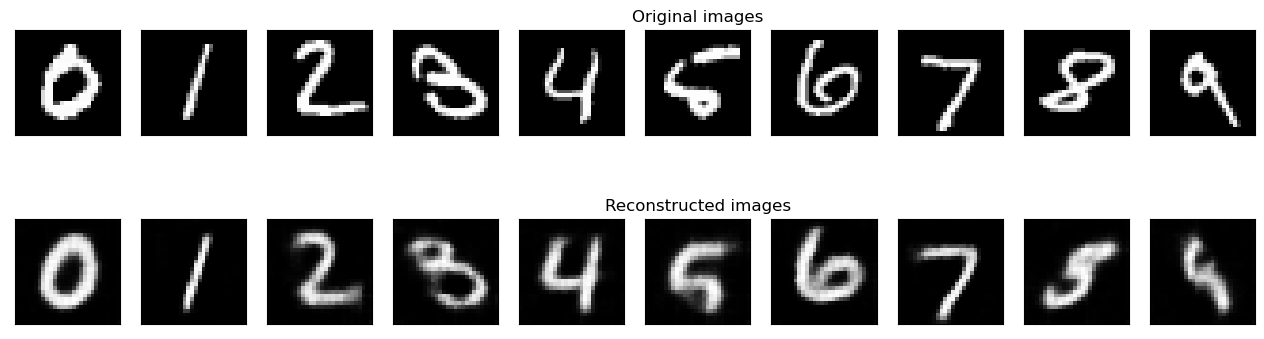

	 partial train loss (single batch): 0.027093
	 partial train loss (single batch): 0.026074
	 partial train loss (single batch): 0.026299
	 partial train loss (single batch): 0.026954
	 partial train loss (single batch): 0.025133
	 partial train loss (single batch): 0.027496
	 partial train loss (single batch): 0.026177
	 partial train loss (single batch): 0.026949
	 partial train loss (single batch): 0.025815
	 partial train loss (single batch): 0.026104
	 partial train loss (single batch): 0.026057
	 partial train loss (single batch): 0.025878
	 partial train loss (single batch): 0.026109
	 partial train loss (single batch): 0.026784
	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.025046
	 partial train loss (single batch): 0.027477
	 partial train loss (single batch): 0.027611
	 partial train loss (single batch): 0.025224
	 partial train loss (single batch): 0.026399
	 partial train loss (single batch): 0.027495
	 partial train loss (single batch

	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.026304
	 partial train loss (single batch): 0.024684
	 partial train loss (single batch): 0.025847
	 partial train loss (single batch): 0.026206
	 partial train loss (single batch): 0.027061
	 partial train loss (single batch): 0.025896
	 partial train loss (single batch): 0.025516

 EPOCH 23/30 	 train loss 0.026179581880569458 	 val loss 0.02648579329252243


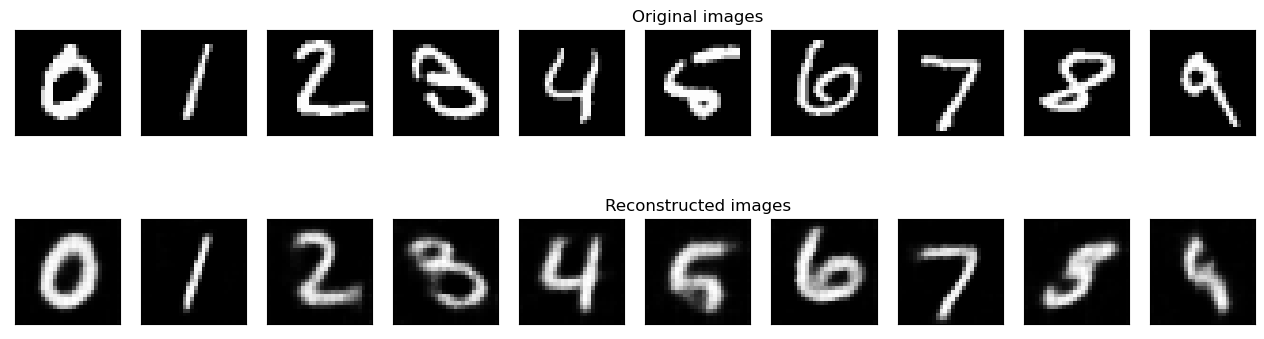

	 partial train loss (single batch): 0.026953
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.026796
	 partial train loss (single batch): 0.024999
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.025997
	 partial train loss (single batch): 0.026853
	 partial train loss (single batch): 0.025637
	 partial train loss (single batch): 0.025992
	 partial train loss (single batch): 0.025949
	 partial train loss (single batch): 0.025713
	 partial train loss (single batch): 0.025921
	 partial train loss (single batch): 0.026631
	 partial train loss (single batch): 0.025211
	 partial train loss (single batch): 0.024965
	 partial train loss (single batch): 0.027386
	 partial train loss (single batch): 0.027475
	 partial train loss (single batch): 0.025025
	 partial train loss (single batch): 0.026279
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch

	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.026219
	 partial train loss (single batch): 0.024547
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch): 0.026140
	 partial train loss (single batch): 0.026980
	 partial train loss (single batch): 0.025824
	 partial train loss (single batch): 0.025465

 EPOCH 24/30 	 train loss 0.02606816403567791 	 val loss 0.02640322595834732


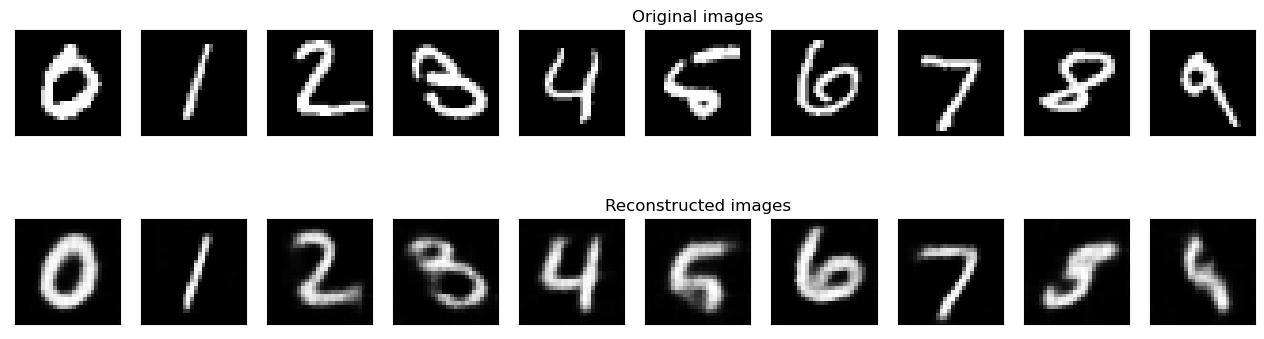

	 partial train loss (single batch): 0.026893
	 partial train loss (single batch): 0.025789
	 partial train loss (single batch): 0.026178
	 partial train loss (single batch): 0.026708
	 partial train loss (single batch): 0.024922
	 partial train loss (single batch): 0.027318
	 partial train loss (single batch): 0.025867
	 partial train loss (single batch): 0.026696
	 partial train loss (single batch): 0.025524
	 partial train loss (single batch): 0.025839
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.025631
	 partial train loss (single batch): 0.025774
	 partial train loss (single batch): 0.026564
	 partial train loss (single batch): 0.025084
	 partial train loss (single batch): 0.024869
	 partial train loss (single batch): 0.027343
	 partial train loss (single batch): 0.027341
	 partial train loss (single batch): 0.024967
	 partial train loss (single batch): 0.026123
	 partial train loss (single batch): 0.027239
	 partial train loss (single batch

	 partial train loss (single batch): 0.025768
	 partial train loss (single batch): 0.026087
	 partial train loss (single batch): 0.024449
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.026002
	 partial train loss (single batch): 0.026902
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.025386

 EPOCH 25/30 	 train loss 0.025961242616176605 	 val loss 0.0263905581086874


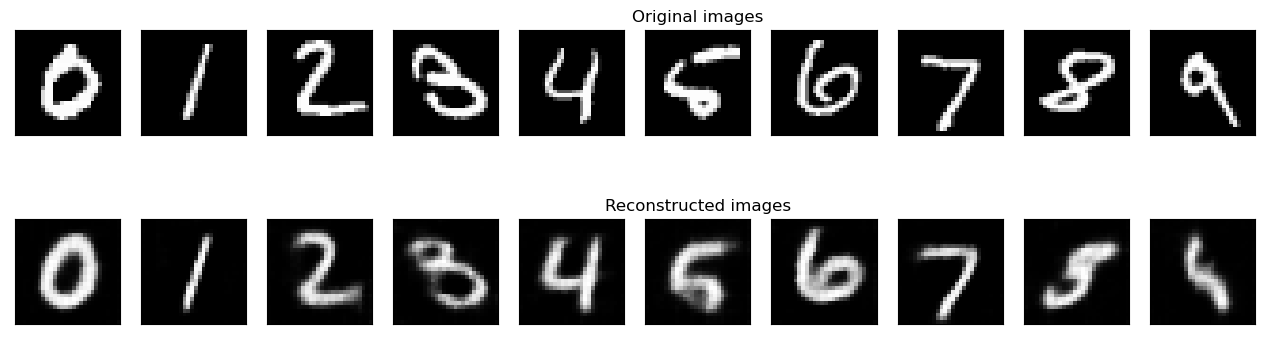

	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.025660
	 partial train loss (single batch): 0.026116
	 partial train loss (single batch): 0.026669
	 partial train loss (single batch): 0.024822
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.025761
	 partial train loss (single batch): 0.026634
	 partial train loss (single batch): 0.025450
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch): 0.025761
	 partial train loss (single batch): 0.025509
	 partial train loss (single batch): 0.025616
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.025033
	 partial train loss (single batch): 0.024794
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.027283
	 partial train loss (single batch): 0.024855
	 partial train loss (single batch): 0.025936
	 partial train loss (single batch): 0.027141
	 partial train loss (single batch

	 partial train loss (single batch): 0.025666
	 partial train loss (single batch): 0.025989
	 partial train loss (single batch): 0.024412
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.025905
	 partial train loss (single batch): 0.026822
	 partial train loss (single batch): 0.025668
	 partial train loss (single batch): 0.025342

 EPOCH 26/30 	 train loss 0.025875799357891083 	 val loss 0.026289544999599457


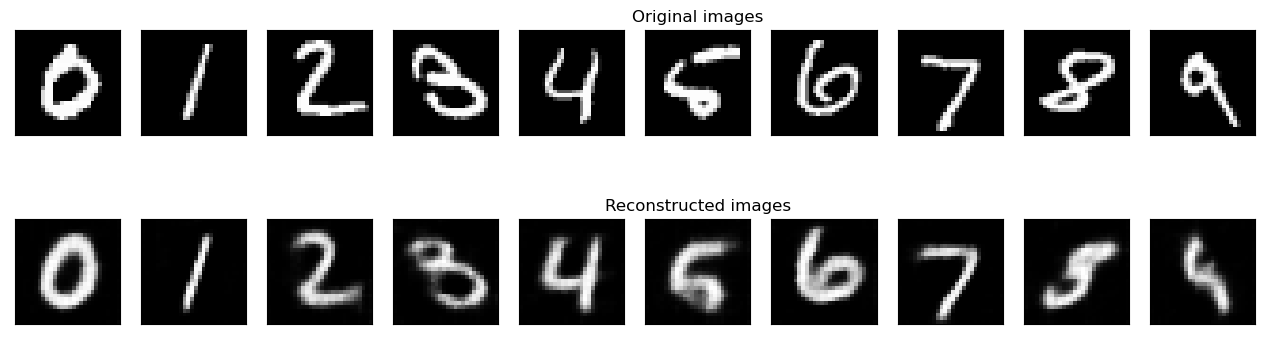

	 partial train loss (single batch): 0.026706
	 partial train loss (single batch): 0.025632
	 partial train loss (single batch): 0.026051
	 partial train loss (single batch): 0.026633
	 partial train loss (single batch): 0.024765
	 partial train loss (single batch): 0.027171
	 partial train loss (single batch): 0.025747
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.025369
	 partial train loss (single batch): 0.025671
	 partial train loss (single batch): 0.025679
	 partial train loss (single batch): 0.025413
	 partial train loss (single batch): 0.025590
	 partial train loss (single batch): 0.026480
	 partial train loss (single batch): 0.025006
	 partial train loss (single batch): 0.024680
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.027217
	 partial train loss (single batch): 0.024746
	 partial train loss (single batch): 0.025889
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch

	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.025632
	 partial train loss (single batch): 0.025950
	 partial train loss (single batch): 0.024379
	 partial train loss (single batch): 0.025433
	 partial train loss (single batch): 0.025843
	 partial train loss (single batch): 0.026729
	 partial train loss (single batch): 0.025582
	 partial train loss (single batch): 0.025280

 EPOCH 27/30 	 train loss 0.025798378512263298 	 val loss 0.026247834786772728


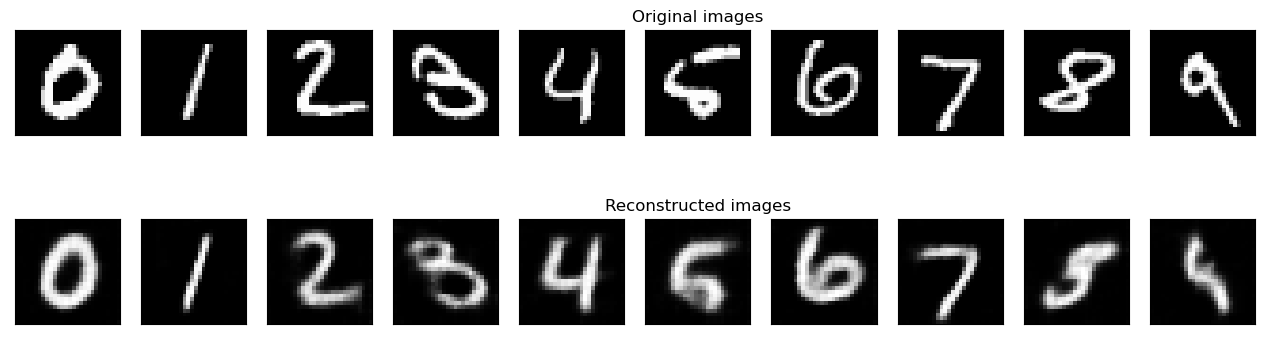

	 partial train loss (single batch): 0.026565
	 partial train loss (single batch): 0.025573
	 partial train loss (single batch): 0.025993
	 partial train loss (single batch): 0.026587
	 partial train loss (single batch): 0.024671
	 partial train loss (single batch): 0.027064
	 partial train loss (single batch): 0.025743
	 partial train loss (single batch): 0.026366
	 partial train loss (single batch): 0.025404
	 partial train loss (single batch): 0.025576
	 partial train loss (single batch): 0.025596
	 partial train loss (single batch): 0.025372
	 partial train loss (single batch): 0.025481
	 partial train loss (single batch): 0.026375
	 partial train loss (single batch): 0.024901
	 partial train loss (single batch): 0.024655
	 partial train loss (single batch): 0.027011
	 partial train loss (single batch): 0.027128
	 partial train loss (single batch): 0.024742
	 partial train loss (single batch): 0.025724
	 partial train loss (single batch): 0.027039
	 partial train loss (single batch

	 partial train loss (single batch): 0.025527
	 partial train loss (single batch): 0.025877
	 partial train loss (single batch): 0.024295
	 partial train loss (single batch): 0.025344
	 partial train loss (single batch): 0.025820
	 partial train loss (single batch): 0.026673
	 partial train loss (single batch): 0.025567
	 partial train loss (single batch): 0.025198

 EPOCH 28/30 	 train loss 0.025719596073031425 	 val loss 0.026187311857938766


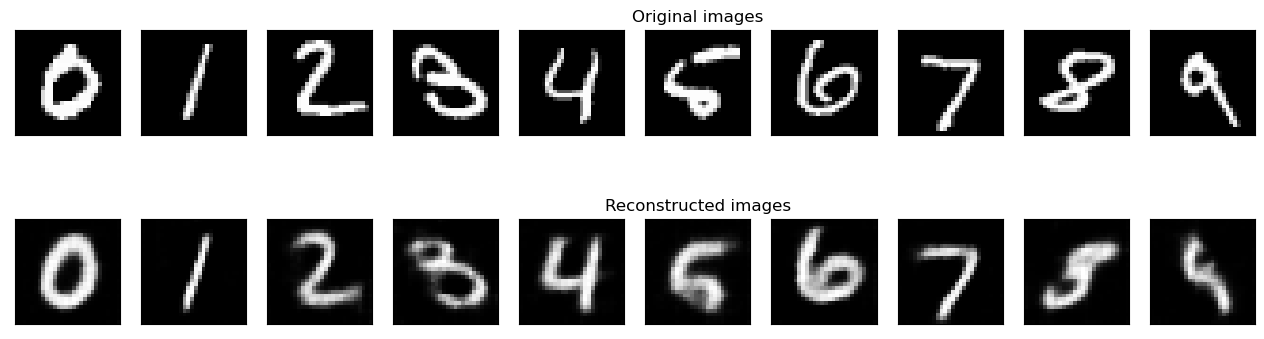

	 partial train loss (single batch): 0.026541
	 partial train loss (single batch): 0.025440
	 partial train loss (single batch): 0.025868
	 partial train loss (single batch): 0.026449
	 partial train loss (single batch): 0.024587
	 partial train loss (single batch): 0.026972
	 partial train loss (single batch): 0.025647
	 partial train loss (single batch): 0.026219
	 partial train loss (single batch): 0.025288
	 partial train loss (single batch): 0.025408
	 partial train loss (single batch): 0.025527
	 partial train loss (single batch): 0.025269
	 partial train loss (single batch): 0.025367
	 partial train loss (single batch): 0.026292
	 partial train loss (single batch): 0.024807
	 partial train loss (single batch): 0.024597
	 partial train loss (single batch): 0.026905
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.024636
	 partial train loss (single batch): 0.025605
	 partial train loss (single batch): 0.026953
	 partial train loss (single batch

	 partial train loss (single batch): 0.025494
	 partial train loss (single batch): 0.025813
	 partial train loss (single batch): 0.024214
	 partial train loss (single batch): 0.025226
	 partial train loss (single batch): 0.025706
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.025516
	 partial train loss (single batch): 0.025056

 EPOCH 29/30 	 train loss 0.0256431195884943 	 val loss 0.026142435148358345


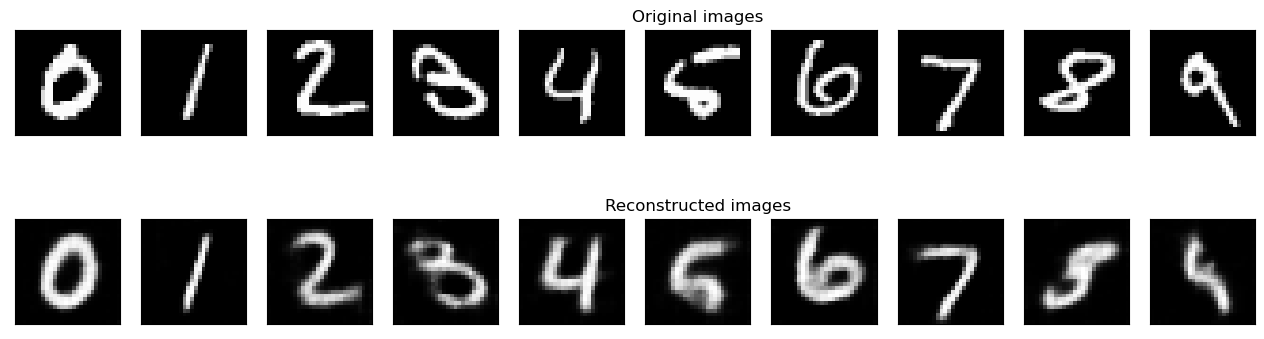

	 partial train loss (single batch): 0.026449
	 partial train loss (single batch): 0.025336
	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.026386
	 partial train loss (single batch): 0.024614
	 partial train loss (single batch): 0.026859
	 partial train loss (single batch): 0.025579
	 partial train loss (single batch): 0.026221
	 partial train loss (single batch): 0.025227
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.025511
	 partial train loss (single batch): 0.025226
	 partial train loss (single batch): 0.025308
	 partial train loss (single batch): 0.026224
	 partial train loss (single batch): 0.024816
	 partial train loss (single batch): 0.024475
	 partial train loss (single batch): 0.026848
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.024653
	 partial train loss (single batch): 0.025623
	 partial train loss (single batch): 0.026897
	 partial train loss (single batch

	 partial train loss (single batch): 0.025802
	 partial train loss (single batch): 0.024173
	 partial train loss (single batch): 0.025202
	 partial train loss (single batch): 0.025631
	 partial train loss (single batch): 0.026591
	 partial train loss (single batch): 0.025434
	 partial train loss (single batch): 0.025120

 EPOCH 30/30 	 train loss 0.025588862597942352 	 val loss 0.02614785172045231


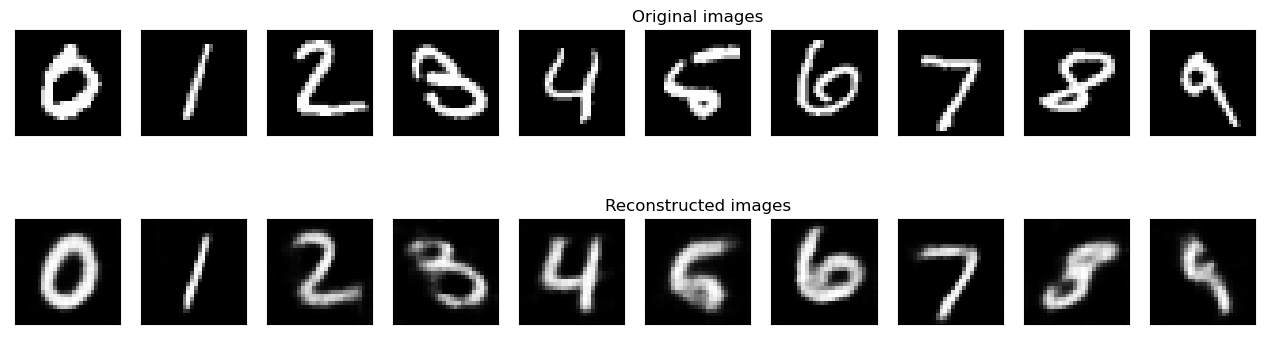

In [8]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [9]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02614785172045231

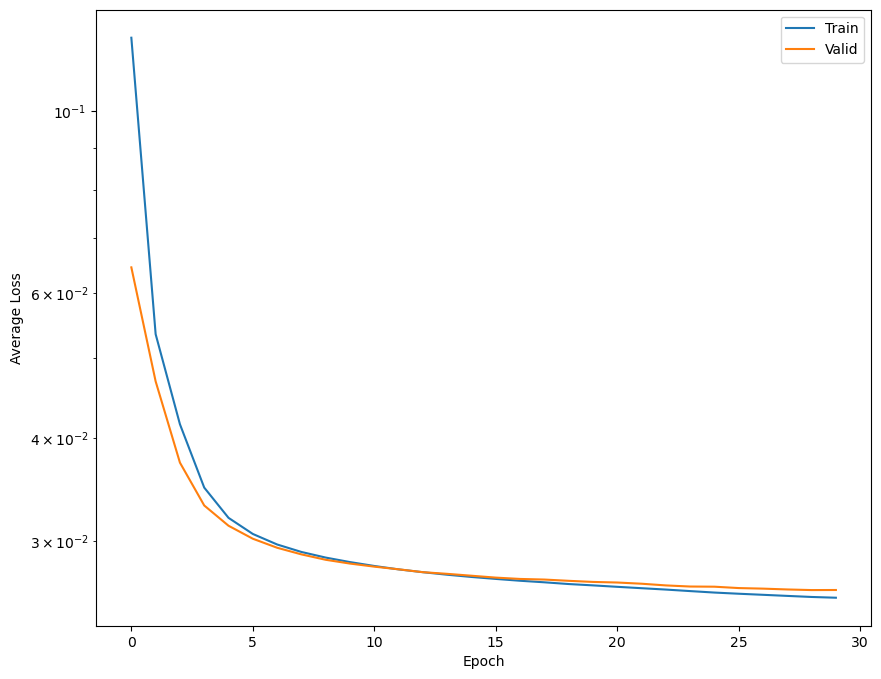

In [10]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## Generate new samples from the random latent code
To generate new images from the latent code, we sample randomly from a normal distribution with the mean and standard deviation of the encoded data. These samples will be passed to the decoder, which will create the reconstructed images.



tensor([-0.0134,  0.0551,  0.1511,  0.0757])
tensor([0.7066, 0.6766, 0.7436, 0.6713])


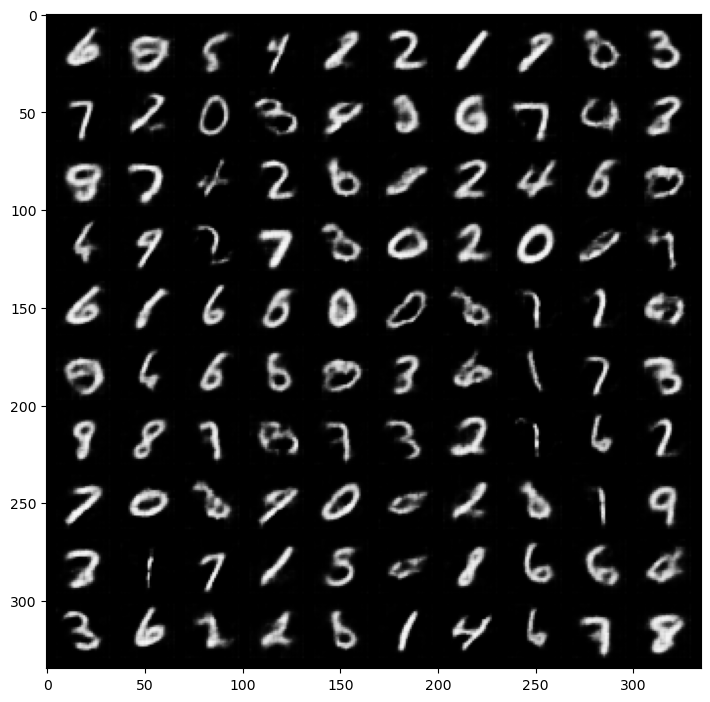

In [18]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

# Visualize the latent space with t-SNE
After we can observe dynamic visualization to see the latent space learned by the autoencoder. First, we create the encoded samples using the test set.

In [21]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

TypeError: 'module' object is not callable